#**Analysis Notebook**

This code will load the prepared data, perform feature engineering, train a predictive model, and evaluate its performance.

--- 1. Loading mock data from CSV files ---
All datasets loaded successfully.

--- 2. Data Preparation and Feature Engineering ---
Feature engineering completed. Final dataset shape: (90582, 9)

--- 3. Model Building and Training ---
Training set size: 63407, Test set size: 27175
Random Forest model trained successfully.

--- 4. Model Evaluation ---
Model Accuracy: 0.6191

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.63      0.76     26384
           1       0.03      0.38      0.05       791

    accuracy                           0.62     27175
   macro avg       0.50      0.50      0.41     27175
weighted avg       0.94      0.62      0.74     27175



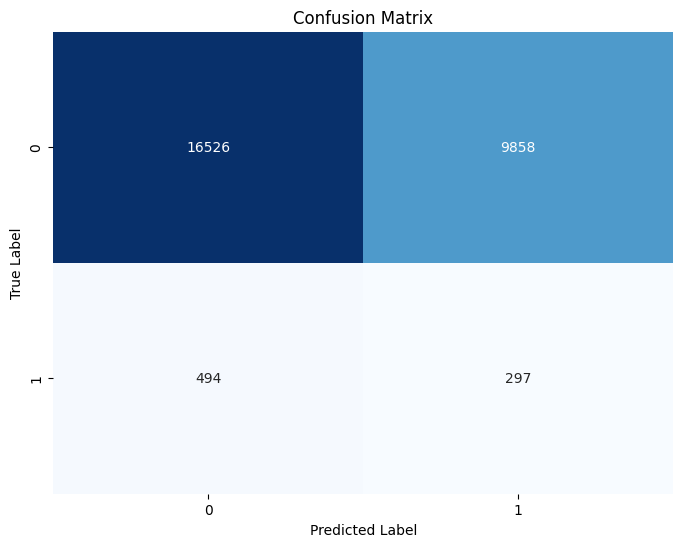


--- 5. Feature Importance Analysis ---
Top 5 most important features for predicting purchase propensity:
avg_video_likes      0.208688
total_engagements    0.202208
avg_video_views      0.200887
num_locations        0.168179
total_tour_stops     0.156465
dtype: float64


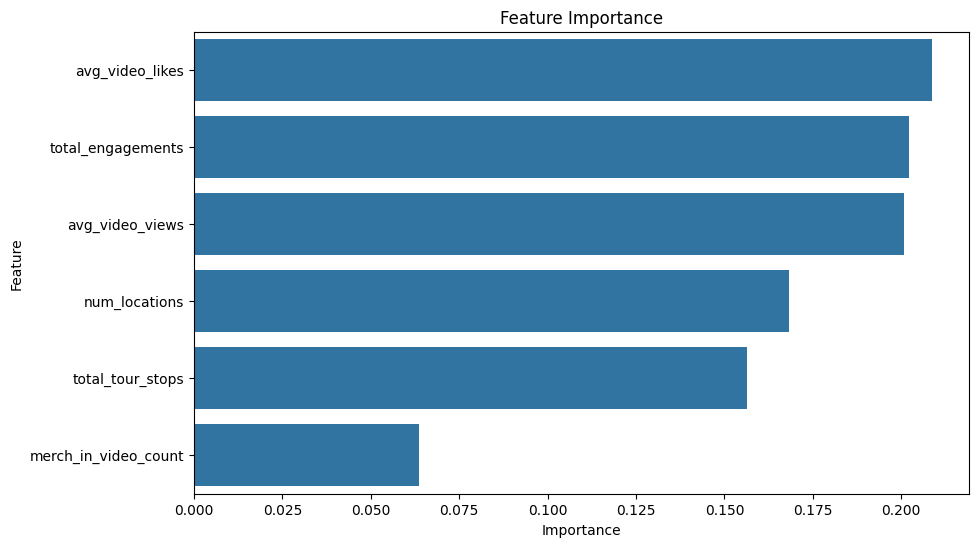


Advanced analysis and model evaluation completed. The next step is to summarize these findings.


In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import timedelta

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# --- 1. Load Mock Data ---
print("--- 1. Loading mock data from CSV files ---")
try:
    merchandise_sales_df = pd.read_csv('merchandise_sales.csv', parse_dates=['sale_date'])
    music_videos_df = pd.read_csv('music_videos.csv', parse_dates=['release_date'])
    fan_engagement_df = pd.read_csv('fan_engagement.csv', parse_dates=['engagement_date'])
    tour_dates_df = pd.read_csv('tour_dates.csv', parse_dates=['tour_date'])
    print("All datasets loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: One or more CSV files not found. Please ensure all files are in the working directory. {e}")
    # Exit if files are not found
    exit()

# --- 2. Data Preparation and Feature Engineering ---
print("\n--- 2. Data Preparation and Feature Engineering ---")

# Create a list of all unique user-artist interactions to serve as our base
# This represents a potential purchase opportunity for each user-artist pair
unique_user_artist = fan_engagement_df[['user_id', 'artist_id']].drop_duplicates()
unique_user_artist = unique_user_artist.dropna()

# Add a target variable: 'made_purchase'
# Merge with sales data to see if a purchase was made for that user-artist pair
unique_user_artist = pd.merge(
    unique_user_artist,
    merchandise_sales_df[['user_id', 'artist_id']].drop_duplicates(),
    on=['user_id', 'artist_id'],
    how='left',
    indicator=True
)
unique_user_artist['made_purchase'] = (unique_user_artist['_merge'] == 'both').astype(int)
unique_user_artist = unique_user_artist.drop(columns=['_merge'])

# Aggregate fan engagement features
fan_engagement_agg = fan_engagement_df.groupby(['user_id', 'artist_id']).agg(
    total_engagements=('engagement_type', 'count'),
    num_locations=('user_location', lambda x: x.nunique())
).reset_index()

# Merge fan engagement features into the main dataframe
model_data = pd.merge(unique_user_artist, fan_engagement_agg, on=['user_id', 'artist_id'], how='left')

# Aggregate video features
video_features = music_videos_df.groupby('artist_id').agg(
    avg_video_views=('video_views', 'mean'),
    avg_video_likes=('video_likes', 'mean'),
    merch_in_video_count=('merch_worn_by_artist', 'sum')
).reset_index()

# Merge video features
model_data = pd.merge(model_data, video_features, on='artist_id', how='left')

# Create features related to tour dates (e.g., number of nearby tour dates)
# This is a simplified approach, a real-world model would use more sophisticated geo-spatial analysis
tour_dates_agg = tour_dates_df.groupby('artist_id').agg(
    total_tour_stops=('tour_id', 'count')
).reset_index()

# Merge tour features
model_data = pd.merge(model_data, tour_dates_agg, on='artist_id', how='left')

# Fill NaNs with 0s for simplicity
model_data = model_data.fillna(0)

# One-hot encode categorical features if needed (e.g., demographics)
# For this mock data, we will stick to numerical features for simplicity.

print("Feature engineering completed. Final dataset shape:", model_data.shape)

# --- 3. Model Building and Training ---
print("\n--- 3. Model Building and Training ---")

# Define features (X) and target (y)
features = ['total_engagements', 'num_locations', 'avg_video_views', 'avg_video_likes', 'merch_in_video_count', 'total_tour_stops']
X = model_data[features]
y = model_data['made_purchase']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")

# Initialize and train the Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)
print("Random Forest model trained successfully.")

# --- 4. Model Evaluation ---
print("\n--- 4. Model Evaluation ---")
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate and print evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# --- 5. Feature Importance ---
print("\n--- 5. Feature Importance Analysis ---")
feature_importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
print("Top 5 most important features for predicting purchase propensity:")
print(feature_importances.head(5))

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

print("\nAdvanced analysis and model evaluation completed. The next step is to summarize these findings.")